# PA004: Health Insurance cross sell

##  Planejamento da solução (IOT)

### Input

### Output

### Tasks

# 0.0. IMPORTS

In [6]:

import pickle 
import requests

import seaborn        as sns
import pandas         as pd
import psycopg2       as pg
import numpy          as np
import scikitplot     as skplt

from matplotlib                    import pyplot                   as plt


from IPython.core.display          import HTML

from sklearn                       import preprocessing            as pp
from sklearn                       import model_selection          as ms
from sklearn                       import ensemble                 as en
from sklearn                       import neighbors                as nk   
from sklearn                       import linear_model             as lm


from flask import Flask, request, Response

import warnings

warnings.filterwarnings("ignore")

## 0.1 Loading Data - Postgres

In [7]:
path = '/home/felipepedrosa/projetos/health_insurance'

In [8]:
#  # Credentials
# host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
# port = 5432
# database = 'comunidadedsdb'
# username = 'member'
# pwd = 'cdspa'

In [9]:
# conn = pg.connect(user = username, password = pwd, host = host, port = port, database = database)

# query_schema = '''
#     SELECT *
#     FROM pa004.users u  INNER JOIN pa004.vehicle v on (u.id = v.id)
#                         INNER JOIN pa004.insurance i on (u.id = i.id)
# '''

# df_raw = pd.read_sql(query_schema, conn)

# conn.close()

# df_raw.to_pickle(path + '/data/raw/df_raw.pkl')

In [10]:
df1 = pd.read_pickle(path + '/data/raw/df_raw.pkl') 

## 0.2 Helper Functions

In [11]:
def my_settings():
    %matplotlib inline
    
    # plotly settings
    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 8
 
    # notebook settings
    display(HTML('<style>.container{width:100% !important;}</style>'))
    np.set_printoptions(suppress=True)
    pd.set_option('display.float_format', '{:.8f}'.format)
    
    # seaborn settings
    sns.set(rc={'figure.figsize':(25,12)})
    sns.set_theme(style = 'darkgrid', font_scale = 1)
my_settings()

In [12]:
def precision_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

def recall_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

# 1.0. Data Description


## 1.1. Organize columns

In [13]:
 # removing duplicated columns
df1 = df1.loc[:, ~ df1.columns.duplicated()]

## 1.2. Data Dimensions

In [14]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 381109
Number of Cols: 12


## 1.3. Data Types

In [15]:
df1.dtypes 

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Check NA

In [16]:
df1.isna().sum() 

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.5. Data Descriptive

In [17]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64','datetime64[ns]'])

### 1.5.1 Numerical Attributes


In [18]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.00000000,381109.00000000,381108.00000000,190555.00000000,190555.00000000,110016.69186992,-0.00000000,-1.20000000
1,age,20.00000000,85.00000000,65.00000000,38.82258357,36.00000000,15.51159067,0.67253900,-0.56565507
2,region_code,0.00000000,52.00000000,52.00000000,26.38880740,28.00000000,13.22987067,-0.11526641,-0.86785712
3,policy_sales_channel,1.00000000,163.00000000,162.00000000,112.03429465,133.00000000,54.20392366,-0.90000812,-0.97081018
4,driving_license,0.00000000,1.00000000,1.00000000,0.99786938,1.00000000,0.04610948,-21.59518153,464.35430215
5,previously_insured,0.00000000,1.00000000,1.00000000,0.45821012,0.00000000,0.49825055,0.16774712,-1.97187125
6,annual_premium,2630.00000000,540165.00000000,537535.00000000,30564.38958146,31669.00000000,17213.13247397,1.76608721,34.00456870
7,vintage,10.00000000,299.00000000,289.00000000,154.34739668,154.00000000,83.67119385,0.00302952,-1.20068804
8,response,0.00000000,1.00000000,1.00000000,0.12256336,0.00000000,0.32793533,2.30190580,3.29878763


# 2.0. Feature Engineering


In [19]:
df2 = df1.copy()

In [20]:
df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.00000000,152.00000000,1,< 1 Year,Yes,0,23367.00000000,249,0
1,13,Female,41,15.00000000,14.00000000,1,1-2 Year,No,1,31409.00000000,221,0
2,18,Female,25,35.00000000,152.00000000,1,< 1 Year,No,1,46622.00000000,299,0
3,31,Female,26,8.00000000,160.00000000,1,< 1 Year,No,0,2630.00000000,136,0
4,39,Male,45,8.00000000,124.00000000,1,1-2 Year,Yes,0,42297.00000000,264,0


In [21]:
# vehicule age
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' ) 

# vehiculde damage
df2['vehicle_damage'] = df2['vehicle_damage'].map({'Yes' : 1 , 'No' : 0})


# 3.0. Data Filtering


In [22]:
df3 = df2.copy()

# 4.0. Exploratoria Data Analysis (EDA)


In [23]:
df4 = df3.copy()

## 4.1. Univariate Analysis


In [24]:
df4.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

<AxesSubplot:xlabel='response', ylabel='age'>

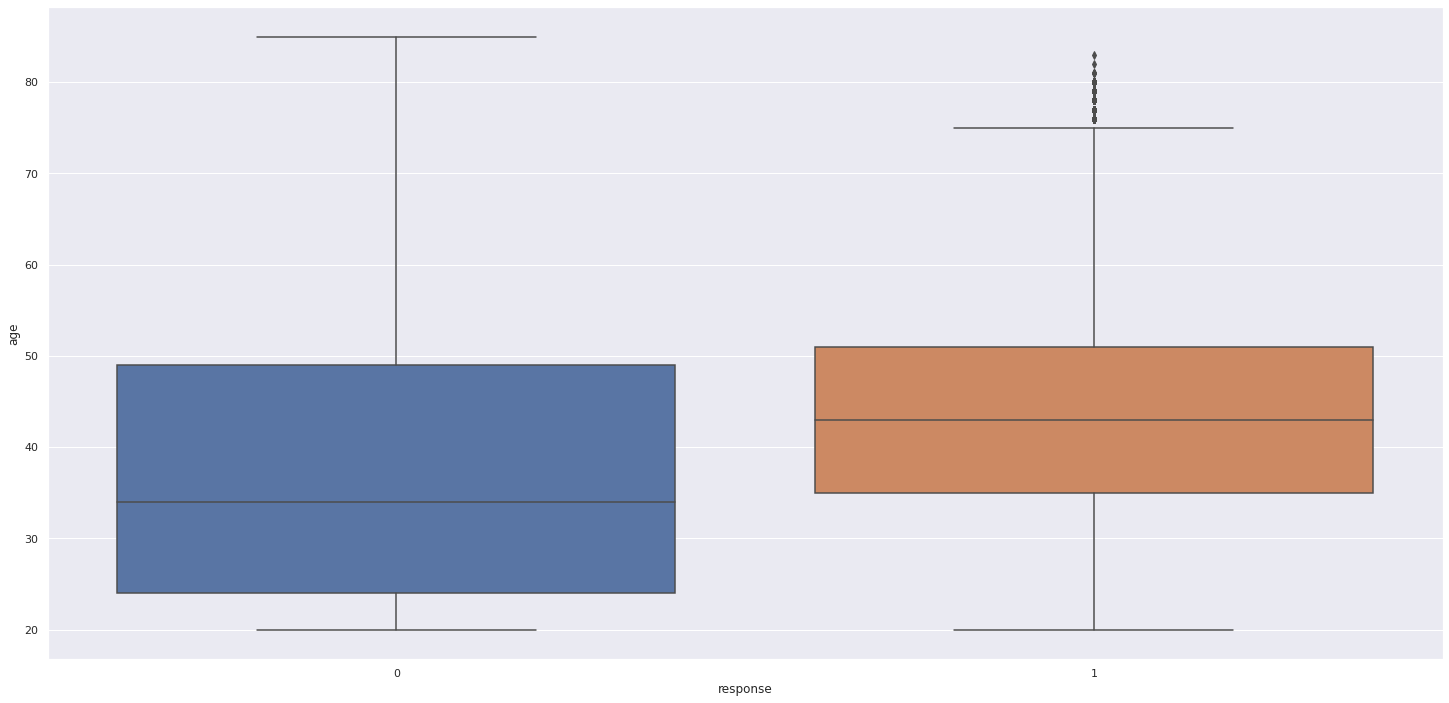

In [25]:
# age
sns.boxplot(x ='response' , y = 'age' , data=df4)

<AxesSubplot:xlabel='age', ylabel='Count'>

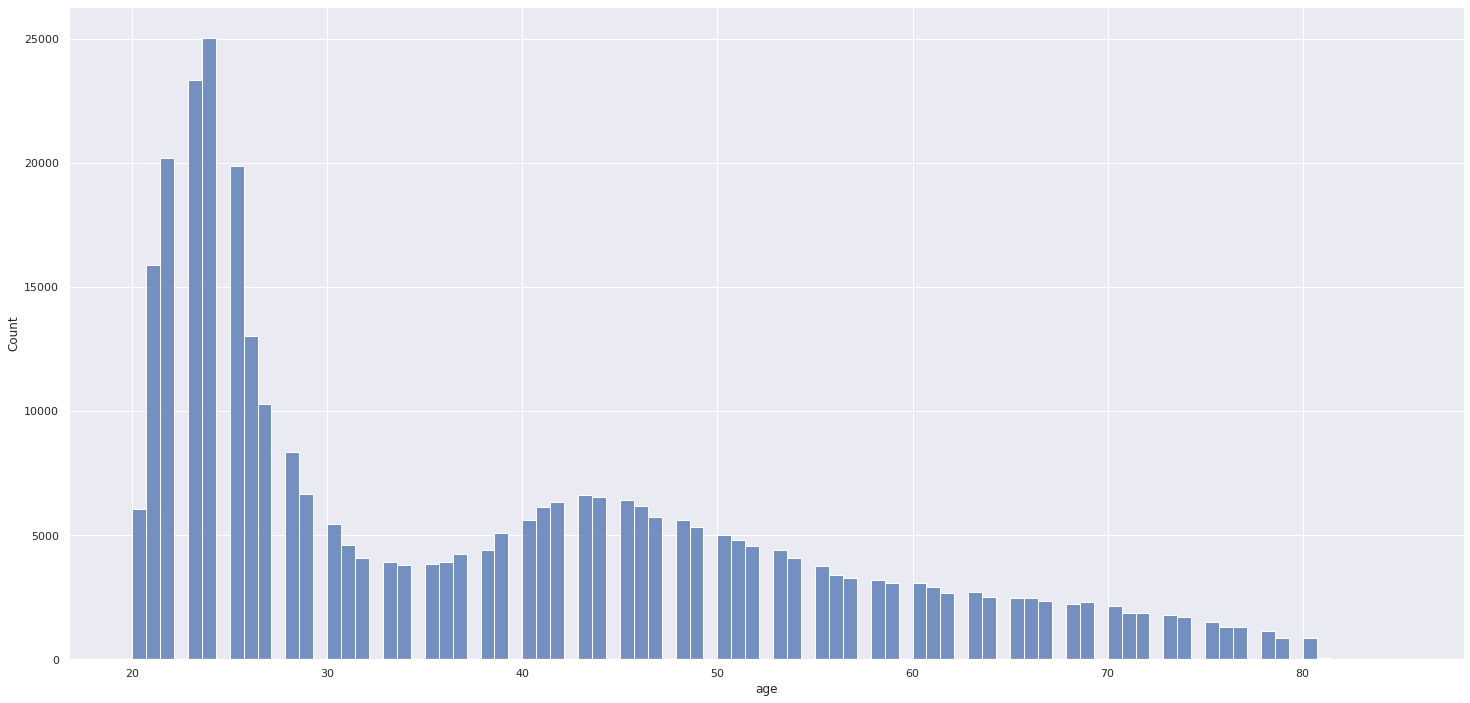

In [26]:
aux00 = df4.loc[df4['response'] == 0,'age']
sns.histplot(aux00)

<AxesSubplot:xlabel='age', ylabel='Count'>

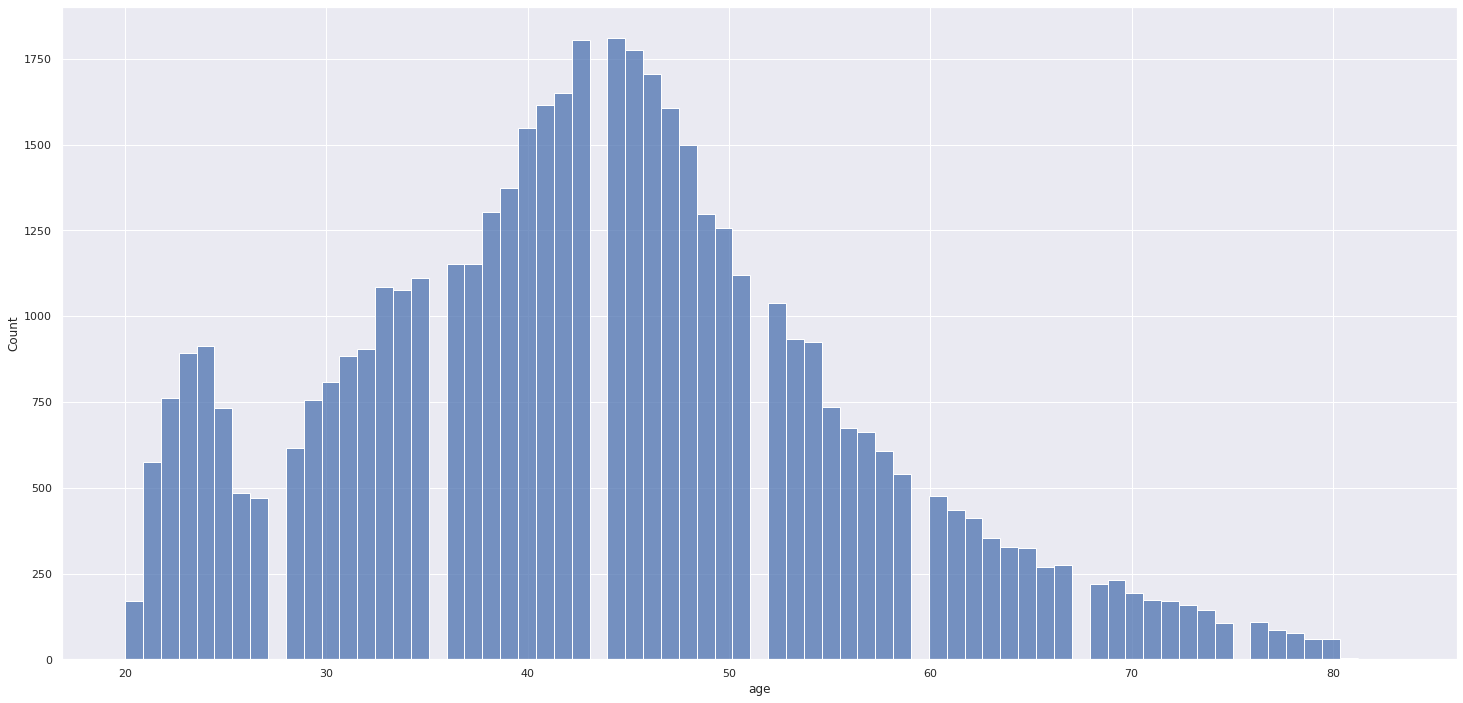

In [27]:
aux00 = df4.loc[df4['response'] == 1,'age']
sns.histplot(aux00)

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

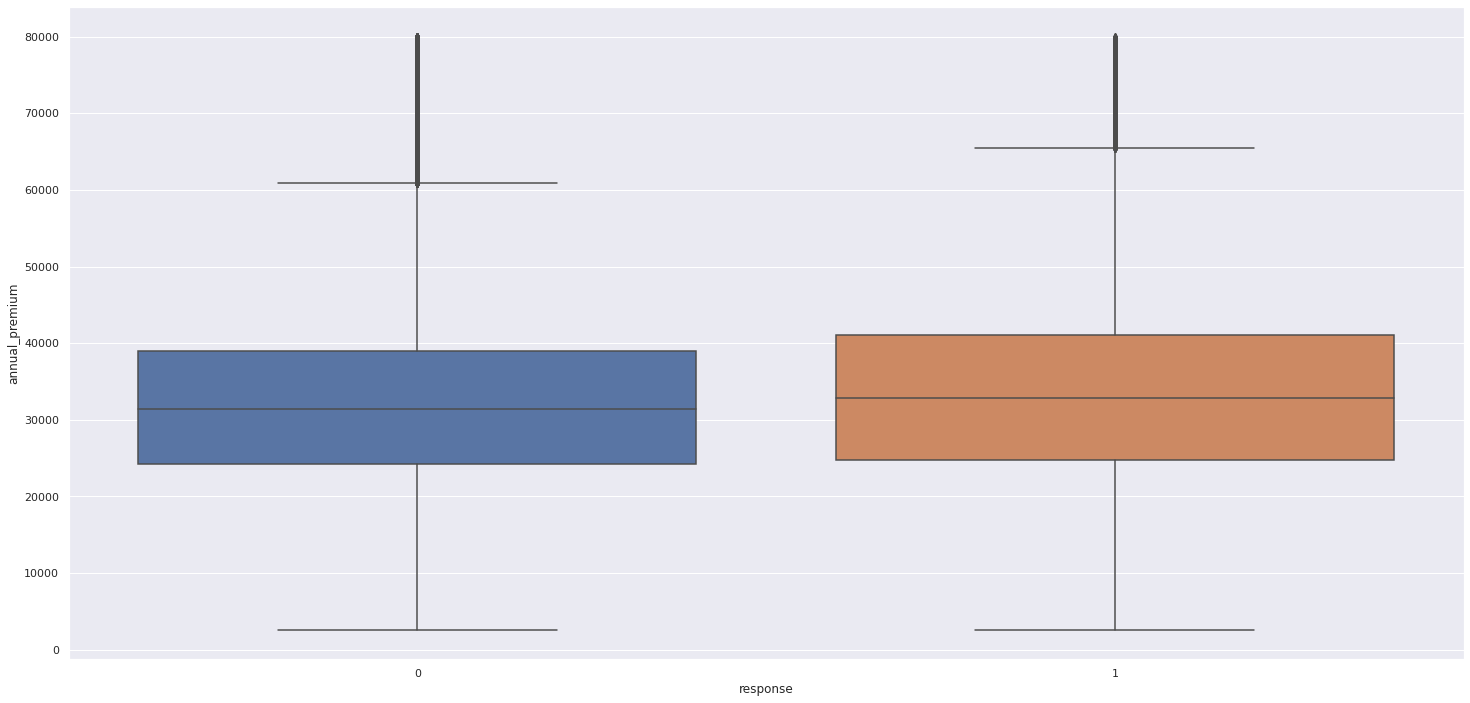

In [28]:
# annual_premium

aux = df4[df4['annual_premium'] < 80000]
sns.boxplot(x ='response' , y = 'annual_premium' , data=aux)


<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

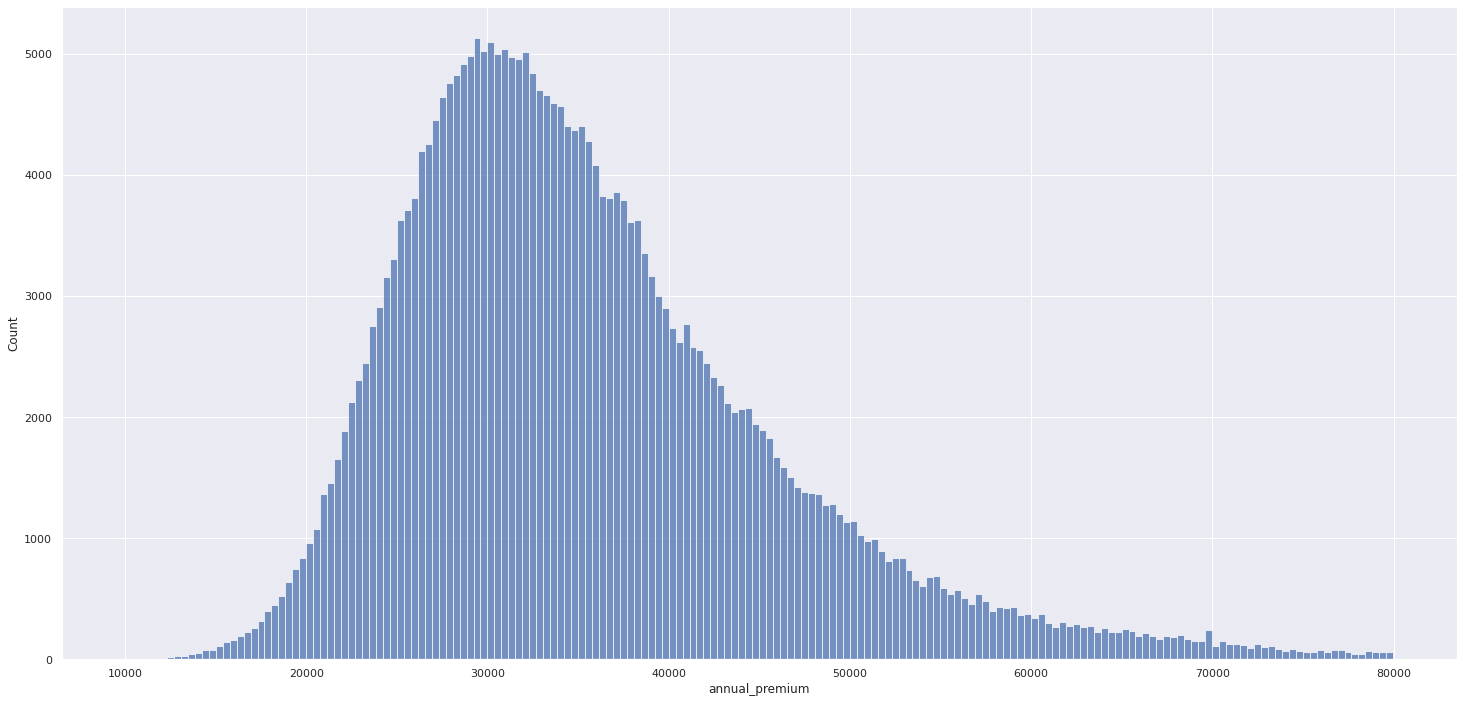

In [29]:
aux = df4[(df4['annual_premium']  > 10000) & (df4['annual_premium'] < 80000)]
aux00 = aux.loc[df4['response'] == 0,'annual_premium']
sns.histplot(aux00)

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

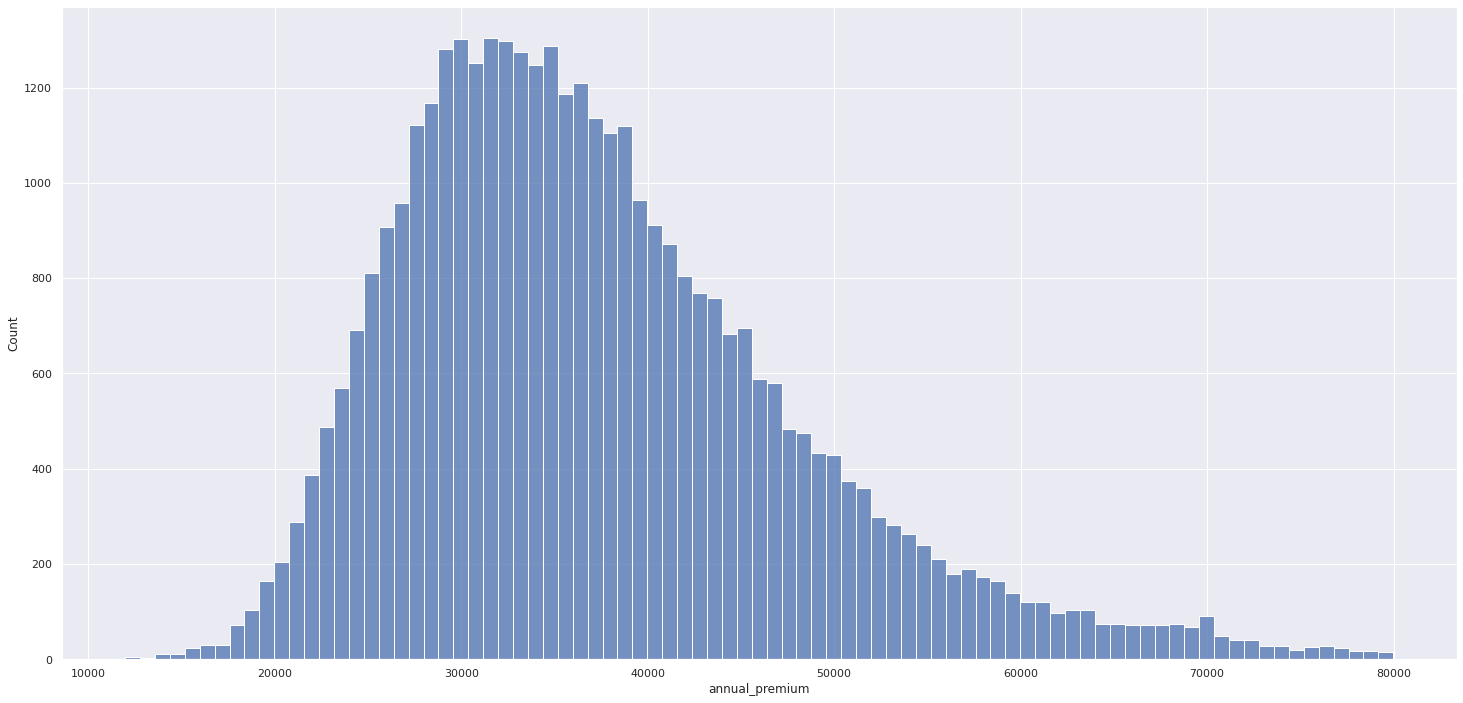

In [30]:
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux00 = aux.loc[df4['response'] == 1,'annual_premium']
sns.histplot(aux00)

In [31]:
# driving_license

aux = df4[['driving_license','response']].groupby('response').sum().reset_index()
aux.head()   
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
# sns.barplot(x ='response' , y = 'driving_license' , data=aux)


In [32]:
aux

,response,driving_license,driving_license_perc
0,0,333628,0.87728276
1,1,46669,0.12271724


<AxesSubplot:xlabel='region_code', ylabel='id'>

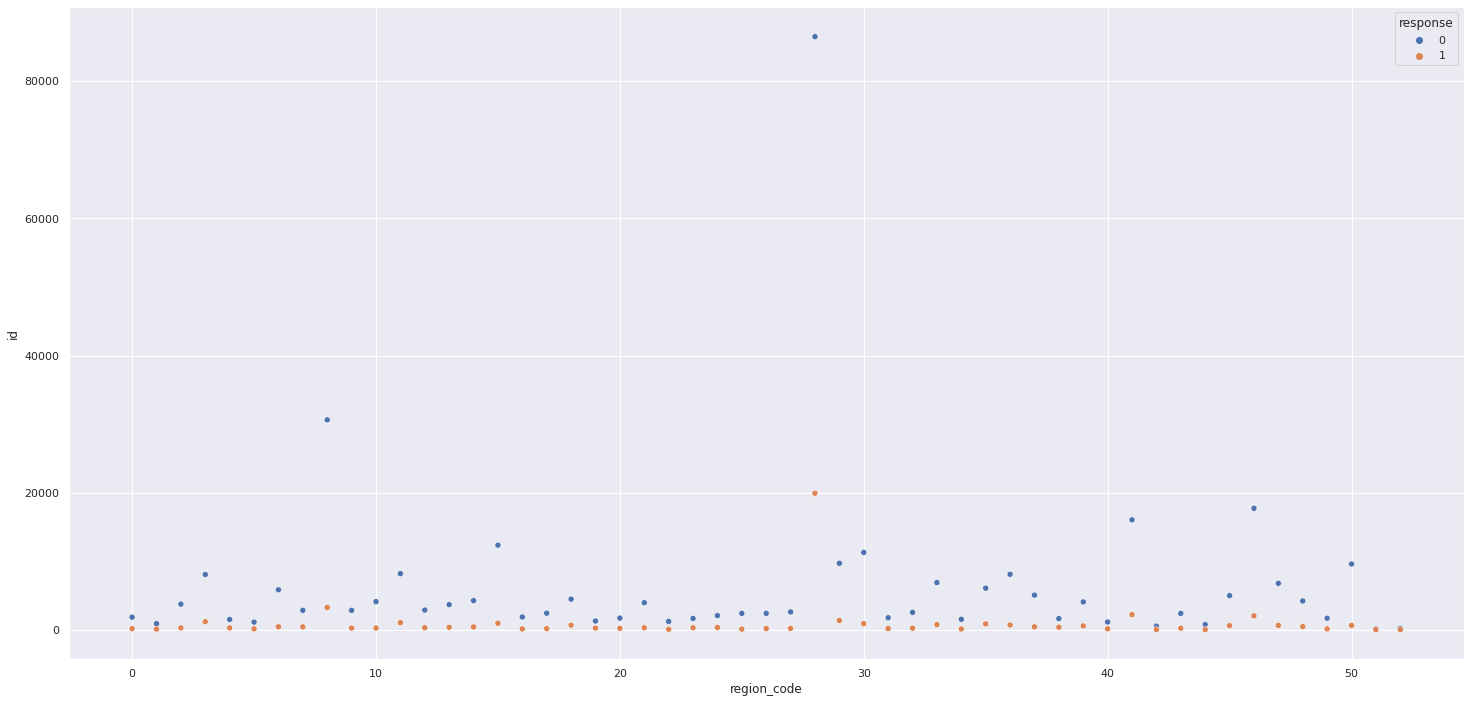

In [33]:
# region_code

aux0 = df4[['id','region_code','response']].groupby(['region_code','response']).count().reset_index()


sns.scatterplot(x= 'region_code' , y='id' , hue='response' , data=aux0)

In [34]:
# previously_insured

pd.crosstab(df4['previously_insured'],df4['response'] ).apply(lambda x: x / x.sum() , axis =1)

response,0,1
previously_insured,,
0,0.77454584,0.22545416
1,0.99909522,0.00090478


In [35]:
# vehicle_age

df4[['vehicle_age' , 'response']].value_counts(normalize= True).reset_index()


,vehicle_age,response,0
0,between_1_2_year,0,0.43428520
1,below_1_year,0,0.41348800
2,between_1_2_year,1,0.09132820
3,over_2_years,0,0.02966343
4,below_1_year,1,0.01889748
5,over_2_years,1,0.01233768


<AxesSubplot:xlabel='response', ylabel='policy_sales_channel'>

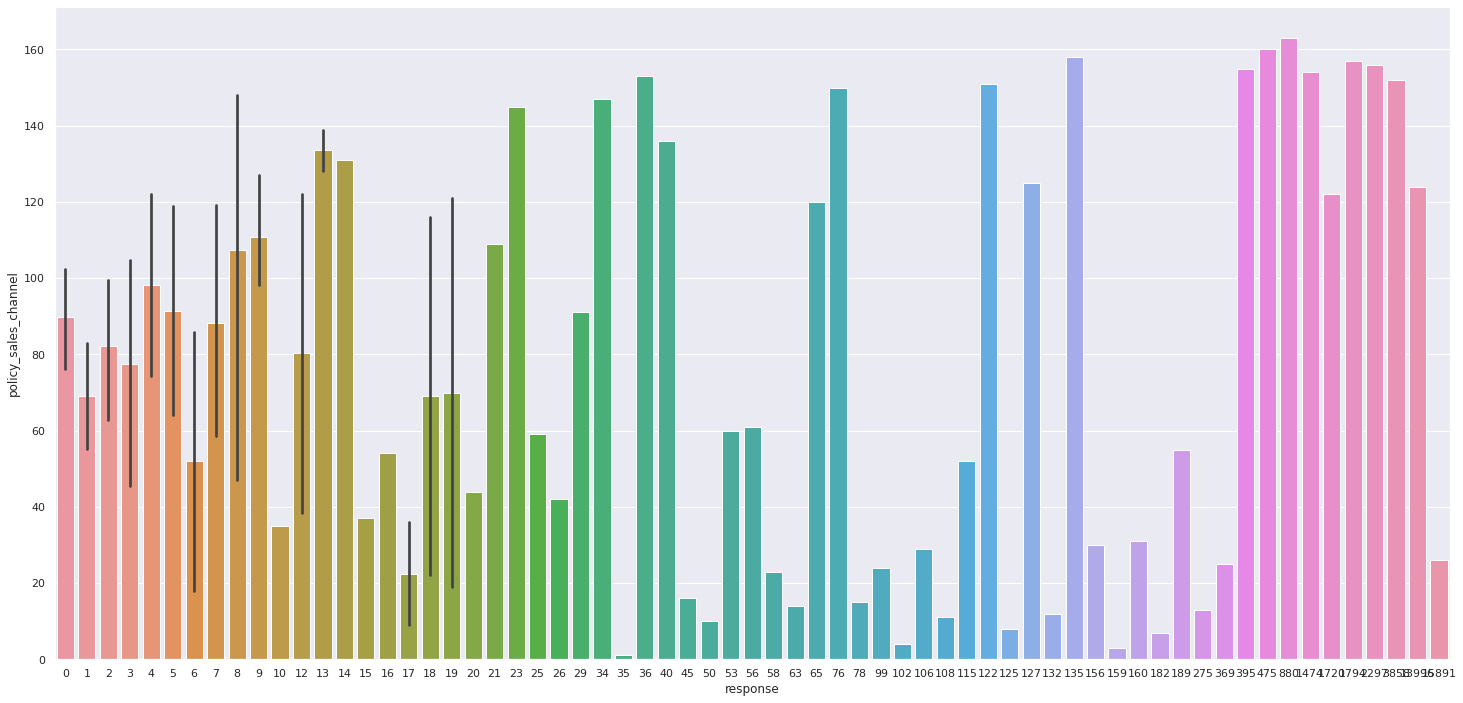

In [36]:
# policy_sales_channel

aux0 = df4[['policy_sales_channel','response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x ='response' , y= 'policy_sales_channel' , data=aux0) 

<AxesSubplot:xlabel='response', ylabel='vintage'>

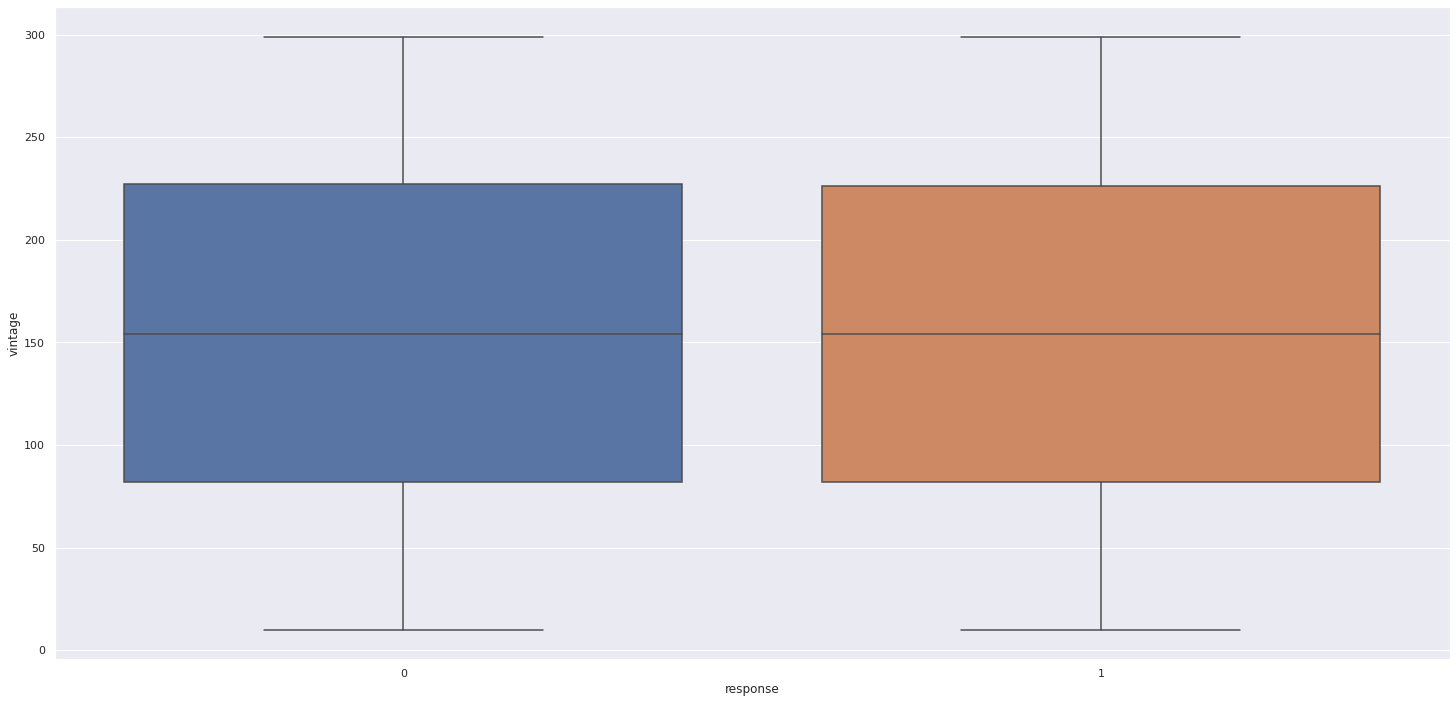

In [37]:
# vintage


sns.boxplot(x ='response' , y = 'vintage' , data=df4)

<AxesSubplot:xlabel='vintage', ylabel='Count'>

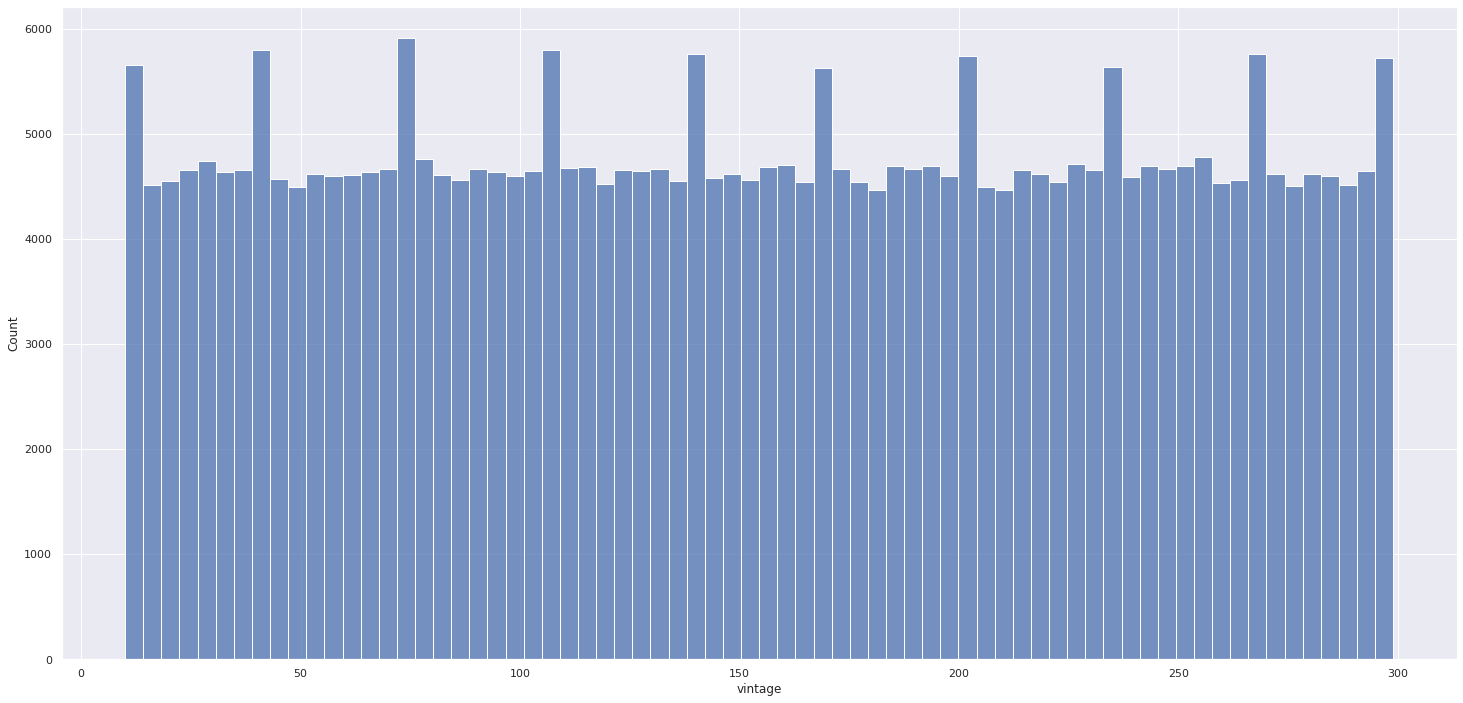

In [38]:
aux00 = df4.loc[df4['response'] == 0,'vintage']
sns.histplot(aux00)

<AxesSubplot:xlabel='vintage', ylabel='Count'>

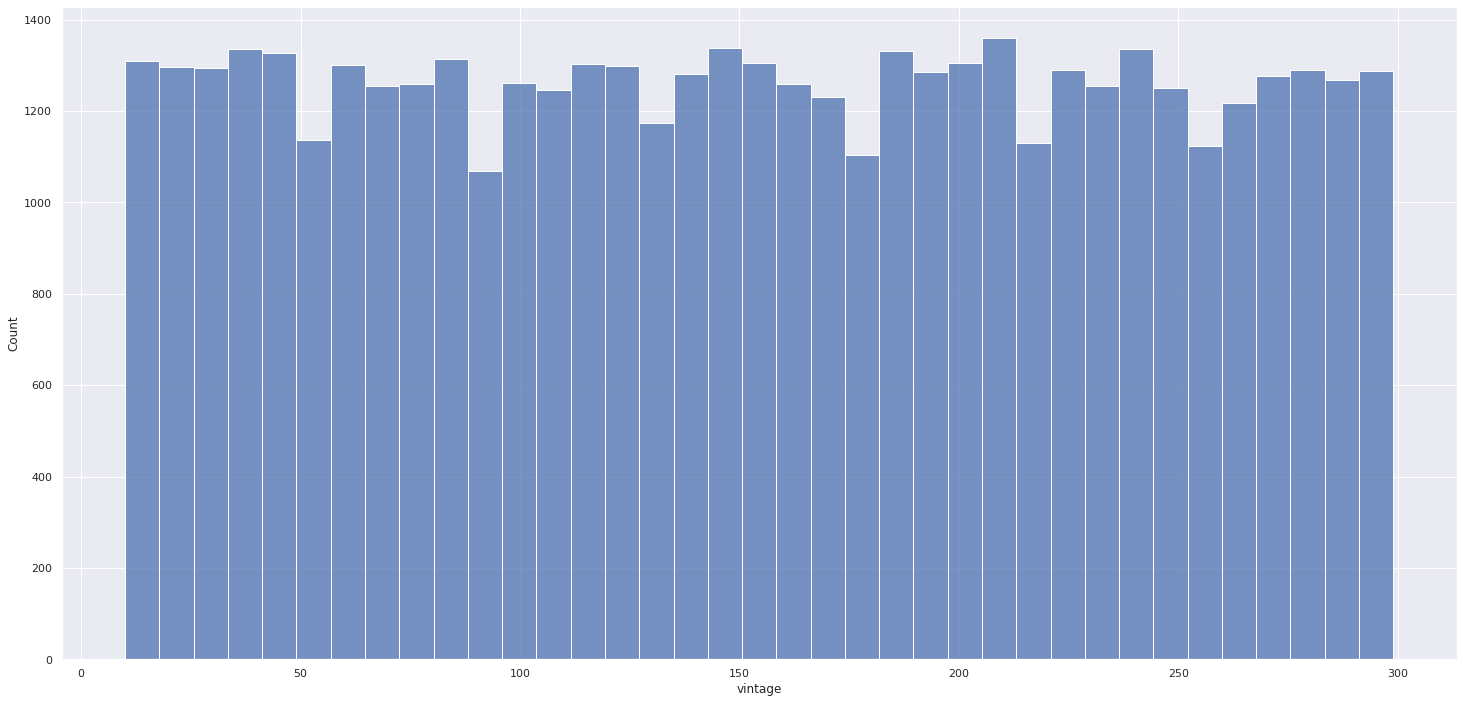

In [39]:
aux00 = df4.loc[df4['response'] == 1,'vintage']
sns.histplot(aux00)

## 4.2. Bivariate Analysis


# 5.0. Data Preparation


In [40]:
df5 = df4.copy()

In [41]:
x = df4.drop('response' , axis=1)
y = df4['response'].copy()


x_train,x_val,y_train,y_val = ms.train_test_split(x,y, test_size = 0.20)

df5 = pd.concat([x_train,y_train], axis=1)

## 5.1. Standardization


In [42]:
ss =pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
pickle.dump(ss, open('../src/features/annual_premium_scaler.pkl' , 'wb'))

## 5.2. Rescaling


In [43]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump(mms_age, open('../src/features/age_scaler.pkl' , 'wb'))

# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
pickle.dump(mms_vintage, open('../src/features/vintage_scaler.pkl' , 'wb'))

## 5.3. Encoder


In [44]:
# gender - Target encoding
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[: , 'gender'] = df5['gender'].map(target_encode_gender)
pickle.dump(target_encode_gender, open('../src/features/target_encode_gender_scaler.pkl' , 'wb'))

# region_code - Target Encoding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[: , 'region_code'] = df5['region_code'].map(target_encode_region_code)
pickle.dump(target_encode_region_code, open('../src/features/target_encode_region_code_scaler.pkl' , 'wb'))

# vehicle_age - One Hot Encoding
df5 = pd.get_dummies(df5 , prefix= 'vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Frequency Encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[: , 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)
pickle.dump(fe_policy_sales_channel, open('../src/features/fe_policy_sales_channel_scaler.pkl' , 'wb'))

# fillna
df5 = df5.fillna(0)

## 5.4. Validation Preparation

In [45]:
# gender
x_val.loc[: , 'gender'] = x_val.loc[: , 'gender'].map(target_encode_region_code)

# Age
x_val.loc[: , 'gender'] = mms_age.fit_transform(x_val[['age']].values)

# vintage
x_val['vintage'] = mms_vintage.fit_transform(x_val[['vintage']].values)

# region_code 
x_val.loc[: , 'region_code'] = x_val.loc[: , 'region_code'].map(target_encode_region_code)

# annual_premium
x_val['annual_premium'] = ss.fit_transform(x_val[['annual_premium']].values)

# vehicle_age 
x_val = pd.get_dummies(x_val , prefix= 'vehicle_age', columns=['vehicle_age'])

# policy_sales_channel 
x_val.loc[: , 'policy_sales_channel'] = x_val['policy_sales_channel'].map(fe_policy_sales_channel)

# fillna
x_val = x_val.fillna(0)


# 6.0. Feature Selection


## 6.1. Feature Importancia

In [46]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# data preparation
x_train_n = df5.drop(['id', 'response'], axis= 1)
y_train_n = y_train.values
forest.fit(x_train_n , y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking: 
                        feature  importances
0                       vintage   0.27184009
0                annual_premium   0.24391459
0                           age   0.16306536
0                   region_code   0.11048773
0                vehicle_damage   0.06901817
0          policy_sales_channel   0.05794018
0            previously_insured   0.05532489
0      vehicle_age_below_1_year   0.01405485
0  vehicle_age_between_1_2_year   0.00671634
0                        gender   0.00499372
0      vehicle_age_over_2_years   0.00216302
0               driving_license   0.00048107


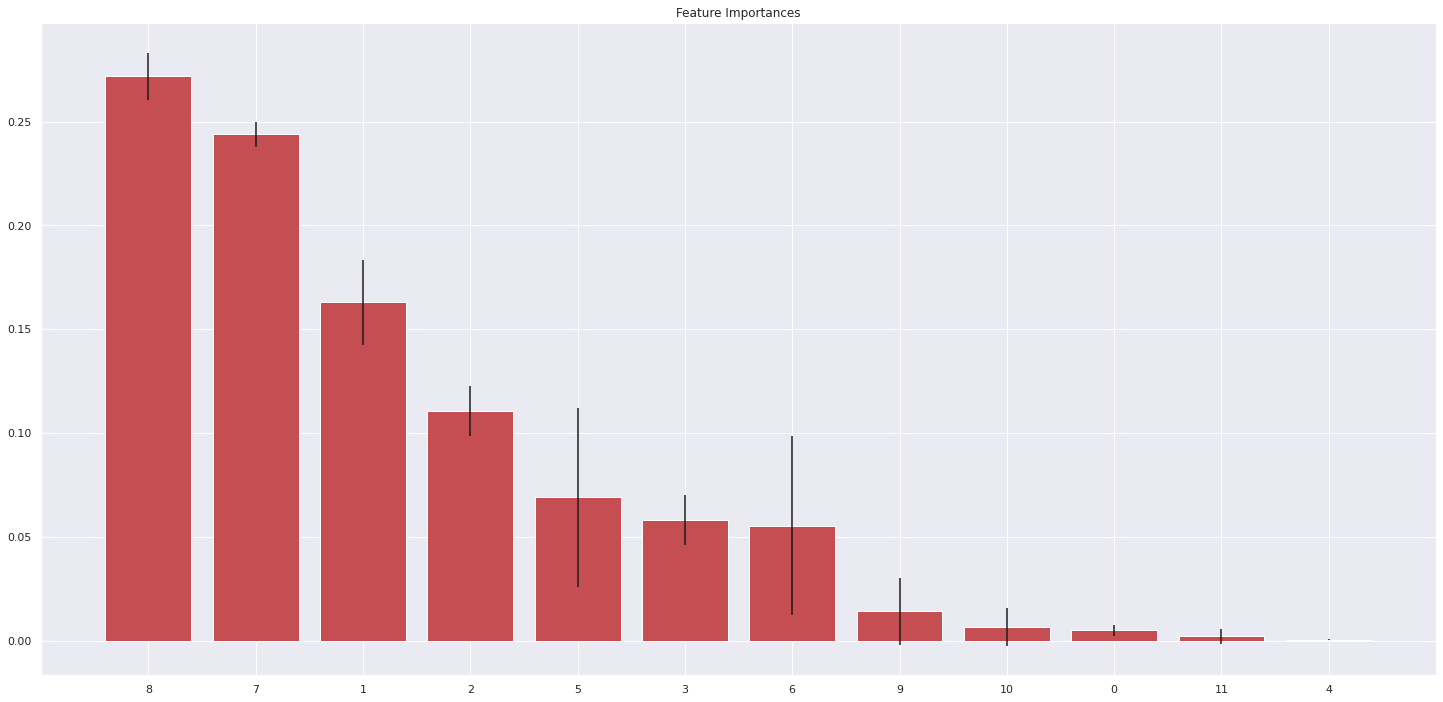

In [47]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_] , axis= 0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print('Feature ranking: ')
df =pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importances': j}, index=[0])
    df = pd.concat([df,aux], axis = 0)
    
print(df.sort_values('importances', ascending= False))
    
# Plot tge umpurity-based feature importances of the forest
plt.figure()
plt.title("Feature Importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color= 'r', yerr= std[indices], align= 'center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()


# 7.0. Machine Learning Modelling


In [48]:
cols_selected = ['vintage','annual_premium','age','region_code','vehicle_damage','policy_sales_channel','previously_insured']

x_train = df5[cols_selected]
x_validation = x_val[cols_selected]
y_validation = y_val.copy()

## 7.1. KNN

In [49]:
# model definition - KNN
knn_model = nk.KNeighborsClassifier(n_neighbors = 500)

# model training
knn_model.fit(x_train , y_train)

# model prediction
yhat_knn = knn_model.predict_proba (x_validation)


## 7.2. Logistic Regression

In [50]:
# model definition - Logistic Regression
lr_model = lm.LogisticRegression(random_state = 42)

# model training
lr_model.fit(x_train , y_train)

# model prediction
yhat_lr = lr_model.predict_proba (x_validation)

## 7.3. Random Forest Classifier

In [51]:
# model definition
RF = en.RandomForestClassifier( n_estimators=250, n_jobs=-1, random_state=42 )

# model fit
RF.fit(x_train , y_train)

# model predict
yhat_rf = RF.predict_proba(x_validation)

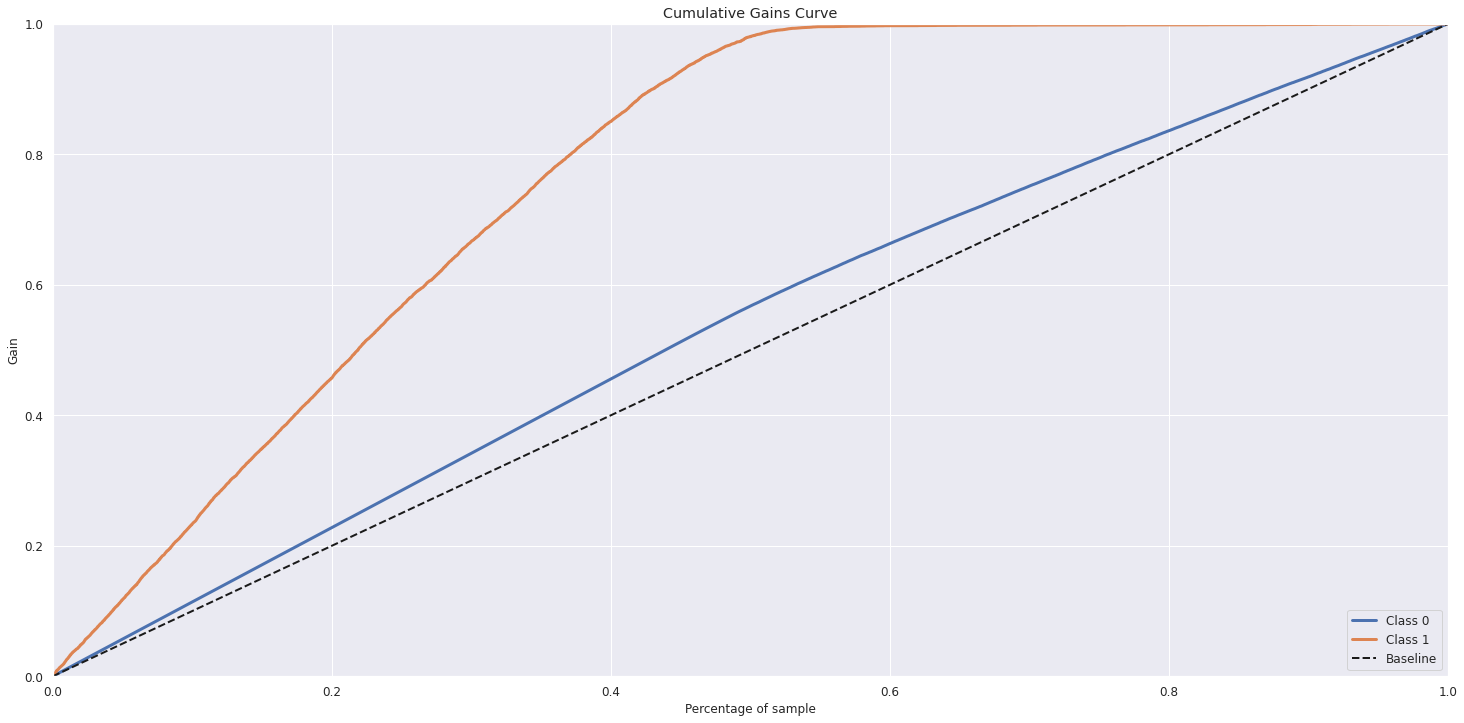

In [52]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_validation , yhat_rf);

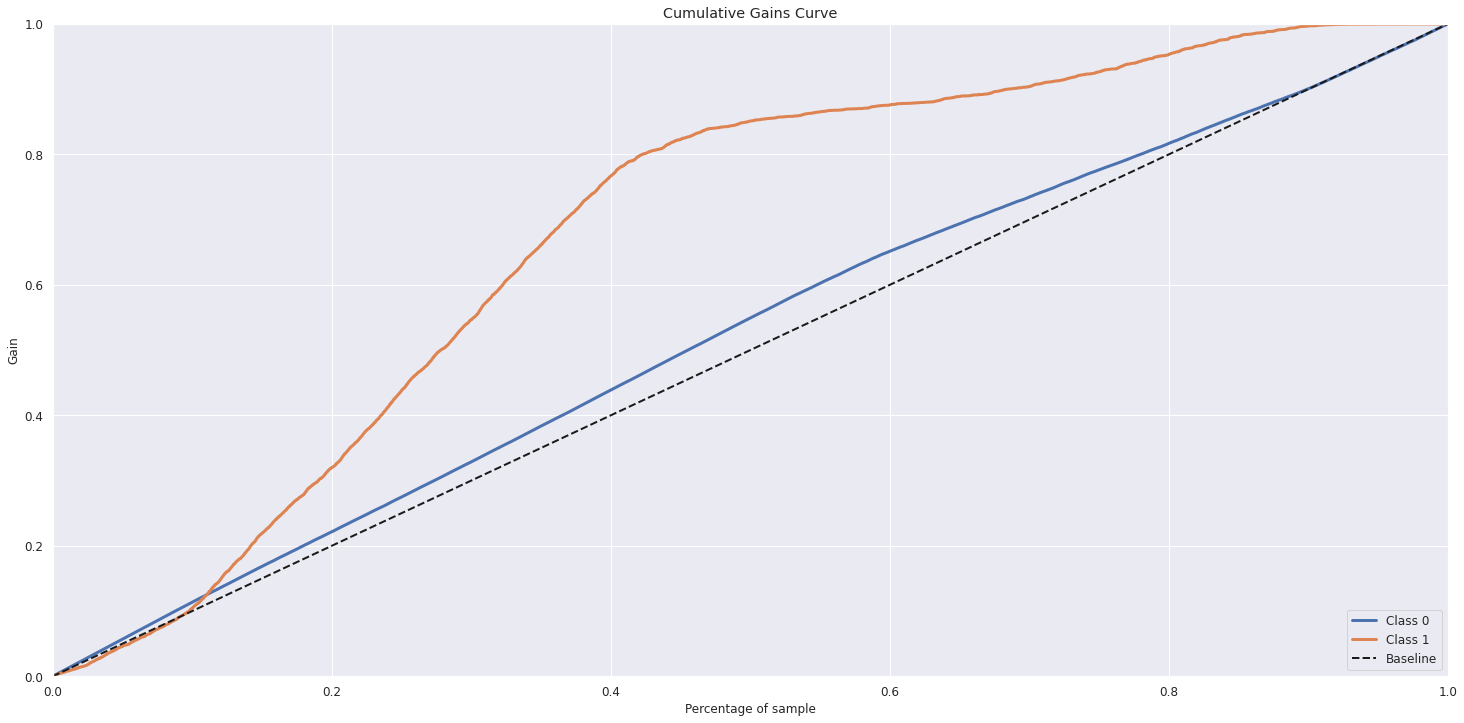

In [53]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_validation , yhat_lr);

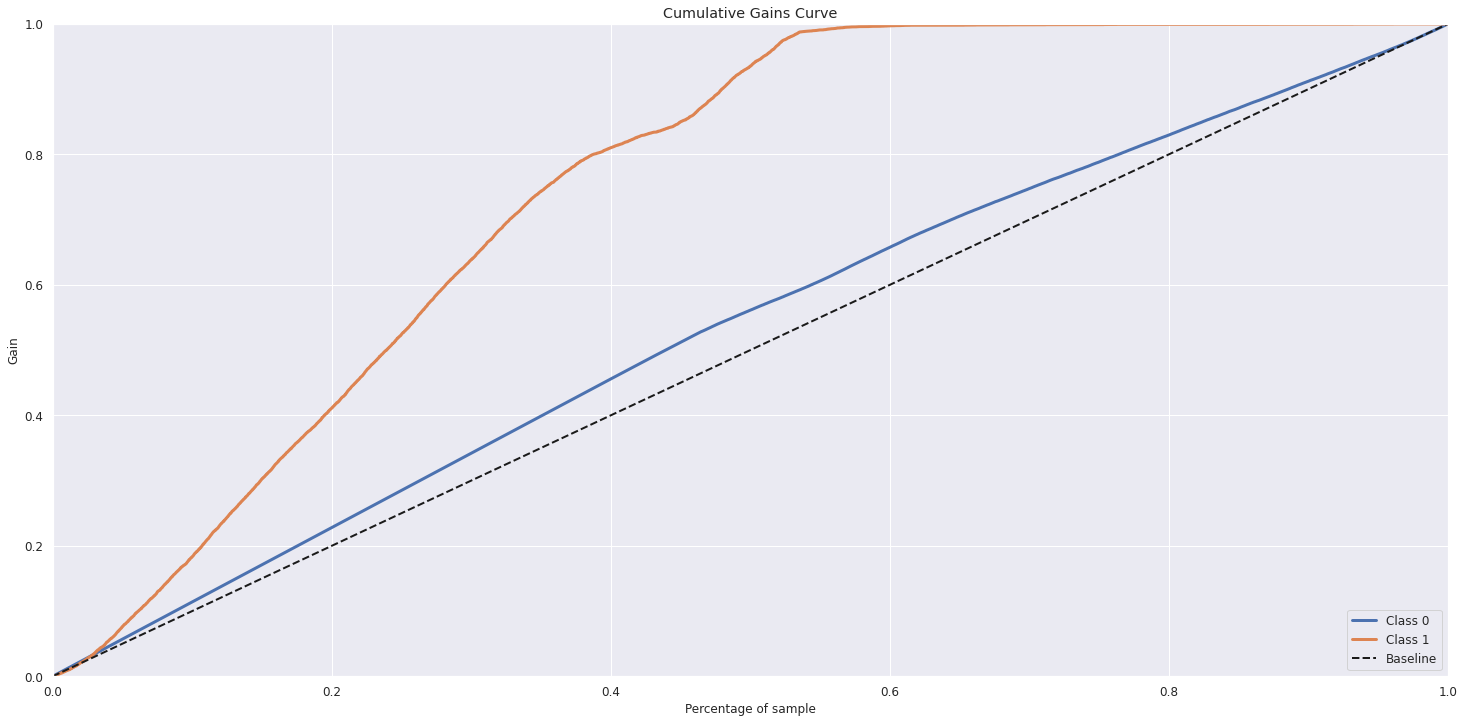

In [54]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_validation , yhat_knn);

# 8.0. Performance Metrics


In [55]:
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

In [56]:
df8.head()

,vintage,annual_premium,age,region_code,vehicle_damage,policy_sales_channel,previously_insured,response
338298,0.87889273,0.34734691,26,0.18606754,0,0.35264541,1,0
68876,0.38062284,0.22254035,22,0.09626241,0,0.35264541,0,0
320475,1.00000000,1.55947625,67,0.18606754,1,0.20903810,0,0
153100,0.17301038,-0.02248517,37,0.13242454,1,0.00081342,0,1
126101,0.26643599,-1.63979472,21,0.10805414,0,0.05752951,0,0


In [57]:

# propensity score
df8['score'] = yhat_knn[:, 1].tolist()

# sorte clients by propensity score
df8 = df8.sort_values( 'score', ascending=False )

# compute precision at k
precision_at_50 = precision_at_k( df8, k=50 )
print( 'Precision at K: {}'.format( precision_at_50 ) )

# compute precision at k
precision_at_50 = recall_at_k( df8, k=50 )
print( 'Recall at K: {}'.format( precision_at_50 ) )


Precision at K: 0.1568627450980392
Recall at K: 0.0008526966531656363


# 9.0. Deploy to Production


In [58]:
# save trained model
# pickle.dump(yhat_rf , open('/home/felipepedrosa/projetos/health_insurance/src/model_training_rf.pkl' , 'wb'))


## 9.1. Heatlh Insurance Class

In [59]:
# class HealthInsurance:
    
#     def __init__(self):
#         self.home_path =                      '/home/felipepedrosa/projetos/health_insurance/'
#         self.annual_premium_scaler =           pickle.load(yhat_et , open(self.home_path + 'src/features/annual_premium_scaler.pkl'))
#         self.age_scaler =                      pickle.load(yhat_et , open(self.home_path + 'src/features/age_scaler.pkl'))
#         self.vintage_scaler =                  pickle.load(yhat_et , open(self.home_path + 'src/features/vintage_scaler.pkl'))
#         self.target_encode_gender_scaler =     pickle.load(yhat_et , open(self.home_path + 'src/features/target_encode_gender_scaler.pkl'))
#         self.target_encode_region_scaler =     pickle.load(yhat_et , open(self.home_path + 'src/features/target_encode_region_scaler.pkl'))
#         self.fe_policy_sales_channel_scaler =  pickle.load(yhat_et , open(self.home_path + 'src/features/fe_policy_sales_channel_scaler.pkl'))
        
# #     def data_cleaning( self, df1 ):
# #         # 1.1. Rename Columns
# #         cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
# #                     'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

# #         # rename 
# #         df1.columns = cols_new
        
# #         return df1 

    
#     def feature_engineering( self, df2 ):
#         # 2.0. Feature Engineering

#         # Vehicle Damage Number
#         df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

#         # Vehicle Age
#         df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )
        
#         return df2
    
    
#     def data_preparation( self, df5 ):
#         # anual premium - StandarScaler
#         df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values )

#         # Age - MinMaxScaler
#         df5['age'] = self.age_scaler.transform( df5[['age']].values )

#         # Vintage - MinMaxScaler
#         df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )

#         # gender - One Hot Encoding / Target Encoding
#         df5.loc[:, 'gender'] = df5['gender'].map( self.target_encode_gender )

#         # region_code - Target Encoding / Frequency Encoding
#         df5.loc[:, 'region_code'] = df5['region_code'].map( self.target_encode_region_code )

#         # vehicle_age - One Hot Encoding / Frequency Encoding
#         df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

#         # policy_sales_channel - Target Encoding / Frequency Encoding
#         df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.fe_policy_sales_channel )
        
#         # Feature Selection
#         cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
#                          'policy_sales_channel']
        
#         return df5[ cols_selected ]
    
    
#     def get_prediction( self, model, original_data, test_data ):
#         # model prediction
#         pred = model.predict_proba( test_data )
        
#         # join prediction into original data
#         original_data['prediction'] = pred
        
#         return original_data.to_json( orient='records', date_format='iso' )

## 9.2. API Hanlder

In [60]:
# # loading model
# path = '/home/felipepedrosa/projetos/health_insurance/'
# model = pickle.load( open( path + 'src/model_training_rf.pkl', 'rb' ) )

# # initialize API
# app = Flask( __name__ )

# @app.route( '/predict', methods=['POST'] )

# def health_insurance_predict():
#     test_json = request.get_json()
    
#     if test_json: # there is data
#         if isinstance( test_json, dict ): # unique example
#             test_raw = pd.DataFrame( test_json, index=[0] )
            
#         else: # multiple example
#             test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
#         # Instantiate Rossmann class
#         pipeline = HealthInsurance()
        
#         # data cleaning
# #         df1 = pipeline.data_cleaning( test_raw )
        
#         # feature engineering
#         df2 = pipeline.feature_engineering( test_raw )
        
#         # data preparation
#         df3 = pipeline.data_preparation( df2 )
        
#         # prediction
#         df_response = pipeline.get_prediction( model, test_raw, df3 )
        
#         return df_response
    
#     else:
#         return Response( '{}', status=200, mimetype='application/json' )
    
# if __name__ == '__main__':
#     app.run( '0.0.0.0', debug=True )

## 9.3. API Tester


In [61]:
# loading test dataset

df_test = x_val
df_test['response'] = y_val

In [62]:
df_test = df_test.sample(10)

In [69]:
df_test.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years,response
92534,357493,0.04615385,23,0.07228464,0.35264541,1,0,1,0.05538660,0.25951557,1,0,0,0
271240,261385,0.36923077,44,0.09626241,0.20903810,1,1,0,0.64724732,0.23875433,0,1,0,0
328327,338018,0.09230769,26,0.05803316,0.35264541,1,0,1,-0.75173898,0.52249135,1,0,0,0
248408,79765,0.33846154,42,0.18606754,0.19410470,1,1,0,0.17554673,0.95501730,0,1,0,0
75809,223579,0.47692308,51,0.10013316,0.19410470,1,1,0,-1.63979472,0.99653979,0,1,0,1


In [70]:
df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.00000000,152.00000000,1,below_1_year,1,0,23367.00000000,249,0
1,13,Female,41,15.00000000,14.00000000,1,between_1_2_year,0,1,31409.00000000,221,0
2,18,Female,25,35.00000000,152.00000000,1,below_1_year,0,1,46622.00000000,299,0
3,31,Female,26,8.00000000,160.00000000,1,below_1_year,0,0,2630.00000000,136,0
4,39,Male,45,8.00000000,124.00000000,1,between_1_2_year,1,0,42297.00000000,264,0


In [63]:
# convert dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [64]:
data

'[{"id": 357493, "gender": 0.046153846153846156, "age": 23, "region_code": 0.07228464419475655, "policy_sales_channel": 0.3526454063308701, "driving_license": 1, "vehicle_damage": 0, "previously_insured": 1, "annual_premium": 0.0553865973397677, "vintage": 0.25951557093425603, "vehicle_age_below_1_year": 1, "vehicle_age_between_1_2_year": 0, "vehicle_age_over_2_years": 0, "response": 0}, {"id": 261385, "gender": 0.36923076923076925, "age": 44, "region_code": 0.09626240637567797, "policy_sales_channel": 0.20903810264130646, "driving_license": 1, "vehicle_damage": 1, "previously_insured": 0, "annual_premium": 0.6472473162062383, "vintage": 0.2387543252595156, "vehicle_age_below_1_year": 0, "vehicle_age_between_1_2_year": 1, "vehicle_age_over_2_years": 0, "response": 0}, {"id": 338018, "gender": 0.09230769230769231, "age": 26, "region_code": 0.05803316180674671, "policy_sales_channel": 0.3526454063308701, "driving_license": 1, "vehicle_damage": 0, "previously_insured": 1, "annual_premium"

In [68]:
# API Call

url = 'http://0.0.0.0:5000/predict'
header = {'Content-type': 'application/json'}     

r = requests.post(url , data = data , headers = header)
print('Status code {}'.format(r.status_code))

Status code 500


In [66]:
d1 = pd.DataFrame(r.json(), columns = r.json([0].keys()))
d1.sort_values('score', ascending = False).head()

JSONDecodeError: [Errno Expecting value] <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN"
  "http://www.w3.org/TR/html4/loose.dtd">
<html>
  <head>
    <title>UnicodeDecodeError: &#x27;utf-8&#x27; codec can&#x27;t decode byte 0x80 in position 0: invalid start byte // Werkzeug Debugger</title>
    <link rel="stylesheet" href="?__debugger__=yes&amp;cmd=resource&amp;f=style.css"
        type="text/css">
    <!-- We need to make sure this has a favicon so that the debugger does
         not accidentally trigger a request to /favicon.ico which might
         change the application's state. -->
    <link rel="shortcut icon"
        href="?__debugger__=yes&amp;cmd=resource&amp;f=console.png">
    <script src="?__debugger__=yes&amp;cmd=resource&amp;f=debugger.js"></script>
    <script type="text/javascript">
      var TRACEBACK = 140113725836496,
          CONSOLE_MODE = false,
          EVALEX = true,
          EVALEX_TRUSTED = false,
          SECRET = "oAhJYPu3CmLzU53aUBN5";
    </script>
  </head>
  <body style="background-color: #fff">
    <div class="debugger">
<h1>UnicodeDecodeError</h1>
<div class="detail">
  <p class="errormsg">UnicodeDecodeError: &#x27;utf-8&#x27; codec can&#x27;t decode byte 0x80 in position 0: invalid start byte</p>
</div>
<h2 class="traceback">Traceback <em>(most recent call last)</em></h2>
<div class="traceback">
  <h3></h3>
  <ul><li><div class="frame" id="frame-140113725835920">
  <h4>File <cite class="filename">"/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py"</cite>,
      line <em class="line">2091</em>,
      in <code class="function">__call__</code></h4>
  <div class="source library"><pre class="line before"><span class="ws">    </span>def __call__(self, environ: dict, start_response: t.Callable) -&gt; t.Any:</pre>
<pre class="line before"><span class="ws">        </span>&quot;&quot;&quot;The WSGI server calls the Flask application object as the</pre>
<pre class="line before"><span class="ws">        </span>WSGI application. This calls :meth:`wsgi_app`, which can be</pre>
<pre class="line before"><span class="ws">        </span>wrapped to apply middleware.</pre>
<pre class="line before"><span class="ws">        </span>&quot;&quot;&quot;</pre>
<pre class="line current"><span class="ws">        </span>return self.wsgi_app(environ, start_response)</pre></div>
</div>

<li><div class="frame" id="frame-140113725836592">
  <h4>File <cite class="filename">"/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py"</cite>,
      line <em class="line">2076</em>,
      in <code class="function">wsgi_app</code></h4>
  <div class="source library"><pre class="line before"><span class="ws">            </span>try:</pre>
<pre class="line before"><span class="ws">                </span>ctx.push()</pre>
<pre class="line before"><span class="ws">                </span>response = self.full_dispatch_request()</pre>
<pre class="line before"><span class="ws">            </span>except Exception as e:</pre>
<pre class="line before"><span class="ws">                </span>error = e</pre>
<pre class="line current"><span class="ws">                </span>response = self.handle_exception(e)</pre>
<pre class="line after"><span class="ws">            </span>except:  # noqa: B001</pre>
<pre class="line after"><span class="ws">                </span>error = sys.exc_info()[1]</pre>
<pre class="line after"><span class="ws">                </span>raise</pre>
<pre class="line after"><span class="ws">            </span>return response(environ, start_response)</pre>
<pre class="line after"><span class="ws">        </span>finally:</pre></div>
</div>

<li><div class="frame" id="frame-140113725836688">
  <h4>File <cite class="filename">"/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py"</cite>,
      line <em class="line">2073</em>,
      in <code class="function">wsgi_app</code></h4>
  <div class="source library"><pre class="line before"><span class="ws">        </span>ctx = self.request_context(environ)</pre>
<pre class="line before"><span class="ws">        </span>error: t.Optional[BaseException] = None</pre>
<pre class="line before"><span class="ws">        </span>try:</pre>
<pre class="line before"><span class="ws">            </span>try:</pre>
<pre class="line before"><span class="ws">                </span>ctx.push()</pre>
<pre class="line current"><span class="ws">                </span>response = self.full_dispatch_request()</pre>
<pre class="line after"><span class="ws">            </span>except Exception as e:</pre>
<pre class="line after"><span class="ws">                </span>error = e</pre>
<pre class="line after"><span class="ws">                </span>response = self.handle_exception(e)</pre>
<pre class="line after"><span class="ws">            </span>except:  # noqa: B001</pre>
<pre class="line after"><span class="ws">                </span>error = sys.exc_info()[1]</pre></div>
</div>

<li><div class="frame" id="frame-140113725836736">
  <h4>File <cite class="filename">"/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py"</cite>,
      line <em class="line">1518</em>,
      in <code class="function">full_dispatch_request</code></h4>
  <div class="source library"><pre class="line before"><span class="ws">            </span>request_started.send(self)</pre>
<pre class="line before"><span class="ws">            </span>rv = self.preprocess_request()</pre>
<pre class="line before"><span class="ws">            </span>if rv is None:</pre>
<pre class="line before"><span class="ws">                </span>rv = self.dispatch_request()</pre>
<pre class="line before"><span class="ws">        </span>except Exception as e:</pre>
<pre class="line current"><span class="ws">            </span>rv = self.handle_user_exception(e)</pre>
<pre class="line after"><span class="ws">        </span>return self.finalize_request(rv)</pre>
<pre class="line after"><span class="ws"></span> </pre>
<pre class="line after"><span class="ws">    </span>def finalize_request(</pre>
<pre class="line after"><span class="ws">        </span>self,</pre>
<pre class="line after"><span class="ws">        </span>rv: t.Union[ResponseReturnValue, HTTPException],</pre></div>
</div>

<li><div class="frame" id="frame-140113725836832">
  <h4>File <cite class="filename">"/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py"</cite>,
      line <em class="line">1516</em>,
      in <code class="function">full_dispatch_request</code></h4>
  <div class="source library"><pre class="line before"><span class="ws">        </span>self.try_trigger_before_first_request_functions()</pre>
<pre class="line before"><span class="ws">        </span>try:</pre>
<pre class="line before"><span class="ws">            </span>request_started.send(self)</pre>
<pre class="line before"><span class="ws">            </span>rv = self.preprocess_request()</pre>
<pre class="line before"><span class="ws">            </span>if rv is None:</pre>
<pre class="line current"><span class="ws">                </span>rv = self.dispatch_request()</pre>
<pre class="line after"><span class="ws">        </span>except Exception as e:</pre>
<pre class="line after"><span class="ws">            </span>rv = self.handle_user_exception(e)</pre>
<pre class="line after"><span class="ws">        </span>return self.finalize_request(rv)</pre>
<pre class="line after"><span class="ws"></span> </pre>
<pre class="line after"><span class="ws">    </span>def finalize_request(</pre></div>
</div>

<li><div class="frame" id="frame-140113725836784">
  <h4>File <cite class="filename">"/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py"</cite>,
      line <em class="line">1502</em>,
      in <code class="function">dispatch_request</code></h4>
  <div class="source library"><pre class="line before"><span class="ws">            </span>getattr(rule, &quot;provide_automatic_options&quot;, False)</pre>
<pre class="line before"><span class="ws">            </span>and req.method == &quot;OPTIONS&quot;</pre>
<pre class="line before"><span class="ws">        </span>):</pre>
<pre class="line before"><span class="ws">            </span>return self.make_default_options_response()</pre>
<pre class="line before"><span class="ws">        </span># otherwise dispatch to the handler for that endpoint</pre>
<pre class="line current"><span class="ws">        </span>return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)</pre>
<pre class="line after"><span class="ws"></span> </pre>
<pre class="line after"><span class="ws">    </span>def full_dispatch_request(self) -&gt; Response:</pre>
<pre class="line after"><span class="ws">        </span>&quot;&quot;&quot;Dispatches the request and on top of that performs request</pre>
<pre class="line after"><span class="ws">        </span>pre and postprocessing as well as HTTP exception catching and</pre>
<pre class="line after"><span class="ws">        </span>error handling.</pre></div>
</div>

<li><div class="frame" id="frame-140113725836928">
  <h4>File <cite class="filename">"/mnt/wsl/PHYSICALDRIVE2/projetos/health_insurance/src/handler.py"</cite>,
      line <em class="line">28</em>,
      in <code class="function">health_insurance_predict</code></h4>
  <div class="source "><pre class="line before"><span class="ws"></span> </pre>
<pre class="line before"><span class="ws">        </span>else: # multiple example</pre>
<pre class="line before"><span class="ws">            </span>test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )</pre>
<pre class="line before"><span class="ws"></span> </pre>
<pre class="line before"><span class="ws">        </span># Instantiate Rossmann class</pre>
<pre class="line current"><span class="ws">        </span>pipeline = HealthInsurance()</pre>
<pre class="line after"><span class="ws"></span> </pre>
<pre class="line after"><span class="ws">        </span># data cleaning</pre>
<pre class="line after"><span class="ws"></span>#         df1 = pipeline.data_cleaning( test_raw )</pre>
<pre class="line after"><span class="ws"></span> </pre>
<pre class="line after"><span class="ws">        </span># feature engineering</pre></div>
</div>

<li><div class="frame" id="frame-140113725837120">
  <h4>File <cite class="filename">"/mnt/wsl/PHYSICALDRIVE2/projetos/health_insurance/src/healthinsurance/HealthInsurance.py"</cite>,
      line <em class="line">11</em>,
      in <code class="function">__init__</code></h4>
  <div class="source "><pre class="line before"><span class="ws"></span> </pre>
<pre class="line before"><span class="ws"></span>class HealthInsurance:</pre>
<pre class="line before"><span class="ws"></span> </pre>
<pre class="line before"><span class="ws">    </span>def __init__(self):</pre>
<pre class="line before"><span class="ws">        </span>self.home_path =                      &#x27;/home/felipepedrosa/projetos/health_insurance/&#x27;</pre>
<pre class="line current"><span class="ws">        </span>self.annual_premium_scaler =           pickle.load( open(self.home_path + &#x27;src/features/annual_premium_scaler.pkl&#x27;))</pre>
<pre class="line after"><span class="ws">        </span>self.age_scaler =                      pickle.load( open(self.home_path + &#x27;src/features/age_scaler.pkl&#x27;))</pre>
<pre class="line after"><span class="ws">        </span>self.vintage_scaler =                  pickle.load( open(self.home_path + &#x27;src/features/vintage_scaler.pkl&#x27;))</pre>
<pre class="line after"><span class="ws">        </span>self.target_encode_gender_scaler =     pickle.load( open(self.home_path + &#x27;src/features/target_encode_gender_scaler.pkl&#x27;))</pre>
<pre class="line after"><span class="ws">        </span>self.target_encode_region_scaler =     pickle.load( open(self.home_path + &#x27;src/features/target_encode_region_scaler.pkl&#x27;))</pre>
<pre class="line after"><span class="ws">        </span>self.fe_policy_sales_channel_scaler =  pickle.load( open(self.home_path + &#x27;src/features/fe_policy_sales_channel_scaler.pkl&#x27;))</pre></div>
</div>

<li><div class="frame" id="frame-140113725837024">
  <h4>File <cite class="filename">"/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/codecs.py"</cite>,
      line <em class="line">322</em>,
      in <code class="function">decode</code></h4>
  <div class="source library"><pre class="line before"><span class="ws">        </span>raise NotImplementedError</pre>
<pre class="line before"><span class="ws"></span> </pre>
<pre class="line before"><span class="ws">    </span>def decode(self, input, final=False):</pre>
<pre class="line before"><span class="ws">        </span># decode input (taking the buffer into account)</pre>
<pre class="line before"><span class="ws">        </span>data = self.buffer + input</pre>
<pre class="line current"><span class="ws">        </span>(result, consumed) = self._buffer_decode(data, self.errors, final)</pre>
<pre class="line after"><span class="ws">        </span># keep undecoded input until the next call</pre>
<pre class="line after"><span class="ws">        </span>self.buffer = data[consumed:]</pre>
<pre class="line after"><span class="ws">        </span>return result</pre>
<pre class="line after"><span class="ws"></span> </pre>
<pre class="line after"><span class="ws">    </span>def reset(self):</pre></div>
</div>
</ul>
  <blockquote>UnicodeDecodeError: &#x27;utf-8&#x27; codec can&#x27;t decode byte 0x80 in position 0: invalid start byte</blockquote>
</div>

<div class="plain">
    <p>
      This is the Copy/Paste friendly version of the traceback.
    </p>
    <textarea cols="50" rows="10" name="code" readonly>Traceback (most recent call last):
  File &quot;/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py&quot;, line 2091, in __call__
    return self.wsgi_app(environ, start_response)
  File &quot;/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py&quot;, line 2076, in wsgi_app
    response = self.handle_exception(e)
  File &quot;/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py&quot;, line 2073, in wsgi_app
    response = self.full_dispatch_request()
  File &quot;/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py&quot;, line 1518, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File &quot;/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py&quot;, line 1516, in full_dispatch_request
    rv = self.dispatch_request()
  File &quot;/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py&quot;, line 1502, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File &quot;/mnt/wsl/PHYSICALDRIVE2/projetos/health_insurance/src/handler.py&quot;, line 28, in health_insurance_predict
    pipeline = HealthInsurance()
  File &quot;/mnt/wsl/PHYSICALDRIVE2/projetos/health_insurance/src/healthinsurance/HealthInsurance.py&quot;, line 11, in __init__
    self.annual_premium_scaler =           pickle.load( open(self.home_path + &#x27;src/features/annual_premium_scaler.pkl&#x27;))
  File &quot;/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/codecs.py&quot;, line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: &#x27;utf-8&#x27; codec can&#x27;t decode byte 0x80 in position 0: invalid start byte</textarea>
</div>
<div class="explanation">
  The debugger caught an exception in your WSGI application.  You can now
  look at the traceback which led to the error.  <span class="nojavascript">
  If you enable JavaScript you can also use additional features such as code
  execution (if the evalex feature is enabled), automatic pasting of the
  exceptions and much more.</span>
</div>
      <div class="footer">
        Brought to you by <strong class="arthur">DON'T PANIC</strong>, your
        friendly Werkzeug powered traceback interpreter.
      </div>
    </div>

    <div class="pin-prompt">
      <div class="inner">
        <h3>Console Locked</h3>
        <p>
          The console is locked and needs to be unlocked by entering the PIN.
          You can find the PIN printed out on the standard output of your
          shell that runs the server.
        <form>
          <p>PIN:
            <input type=text name=pin size=14>
            <input type=submit name=btn value="Confirm Pin">
        </form>
      </div>
    </div>
  </body>
</html>

<!--

Traceback (most recent call last):
  File "/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py", line 2091, in __call__
    return self.wsgi_app(environ, start_response)
  File "/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py", line 2076, in wsgi_app
    response = self.handle_exception(e)
  File "/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py", line 2073, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py", line 1518, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py", line 1516, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/site-packages/flask/app.py", line 1502, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/mnt/wsl/PHYSICALDRIVE2/projetos/health_insurance/src/handler.py", line 28, in health_insurance_predict
    pipeline = HealthInsurance()
  File "/mnt/wsl/PHYSICALDRIVE2/projetos/health_insurance/src/healthinsurance/HealthInsurance.py", line 11, in __init__
    self.annual_premium_scaler =           pickle.load( open(self.home_path + 'src/features/annual_premium_scaler.pkl'))
  File "/home/felipepedrosa/anaconda3/envs/health_insurance/lib/python3.9/codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

-->
: 0